In [63]:
import math
import torch 
import gpytorch
import matplotlib.pyplot as plt 
import numpy as np 

In [64]:
train_x = torch.Tensor([0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02,0.01, 0.009, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002, 0.001, 0.0009, 0.0008])

In [65]:
train_x

tensor([0.1000, 0.0900, 0.0800, 0.0700, 0.0600, 0.0500, 0.0400, 0.0300, 0.0200,
        0.0100, 0.0090, 0.0080, 0.0070, 0.0060, 0.0050, 0.0040, 0.0030, 0.0020,
        0.0010, 0.0009, 0.0008])

In [66]:
train_y = torch.Tensor([9.34, 28.98, 39.05, 9.36, 9.41, 69.7, 53.63, 129.48, 181.43, 198.67, 196.13, 195.13, 196.3, 196.73, 197.87, 196.87, 198, 197.63, 197.33, 197.4, 197.33 ])

In [67]:
train_y

tensor([  9.3400,  28.9800,  39.0500,   9.3600,   9.4100,  69.7000,  53.6300,
        129.4800, 181.4300, 198.6700, 196.1300, 195.1300, 196.3000, 196.7300,
        197.8700, 196.8700, 198.0000, 197.6300, 197.3300, 197.4000, 197.3300])

In [68]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [69]:
iterations = 50
# training models
model.train()
likelihood.train()

# using adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Loss for GPs
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


In [70]:
for i in range(iterations):
    # Zero gradients
    optimizer.zero_grad()
    output = model(train_x)

    loss = -mll(output, train_y)
    loss.backward()
    '''print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, iterations, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))'''
    optimizer.step()

In [71]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 0.1, 500)
    test_x = torch.Tensor(test_x)
    print(test_x)
    observed_pred = likelihood(model(test_x))

tensor([0.0000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010, 0.0012, 0.0014, 0.0016,
        0.0018, 0.0020, 0.0022, 0.0024, 0.0026, 0.0028, 0.0030, 0.0032, 0.0034,
        0.0036, 0.0038, 0.0040, 0.0042, 0.0044, 0.0046, 0.0048, 0.0050, 0.0052,
        0.0054, 0.0056, 0.0058, 0.0060, 0.0062, 0.0064, 0.0066, 0.0068, 0.0070,
        0.0072, 0.0074, 0.0076, 0.0078, 0.0080, 0.0082, 0.0084, 0.0086, 0.0088,
        0.0090, 0.0092, 0.0094, 0.0096, 0.0098, 0.0100, 0.0102, 0.0104, 0.0106,
        0.0108, 0.0110, 0.0112, 0.0114, 0.0116, 0.0118, 0.0120, 0.0122, 0.0124,
        0.0126, 0.0128, 0.0130, 0.0132, 0.0134, 0.0136, 0.0138, 0.0140, 0.0142,
        0.0144, 0.0146, 0.0148, 0.0150, 0.0152, 0.0154, 0.0156, 0.0158, 0.0160,
        0.0162, 0.0164, 0.0166, 0.0168, 0.0170, 0.0172, 0.0174, 0.0176, 0.0178,
        0.0180, 0.0182, 0.0184, 0.0186, 0.0188, 0.0190, 0.0192, 0.0194, 0.0196,
        0.0198, 0.0200, 0.0202, 0.0204, 0.0206, 0.0208, 0.0210, 0.0212, 0.0214,
        0.0216, 0.0218, 0.0220, 0.0222, 

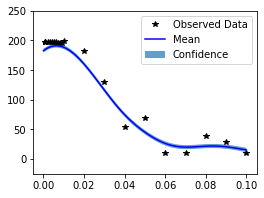

In [72]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.7)
    ax.set_ylim([-25,250])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])